
# Redes neuronales convolucionales

Implementaremos y compararemos diferentes arquitecturas para la tarea de clasificar imágenes satelitales. En concreto:

- Se implementará una red completamente conectada para establecer un "baseline"
- Se implementará una red convolutional pequeña
- Se implementará una red convolucional profunda (Resnet50) pre-entrenada en Imagenet


#### Author:  Adonis González Godoy

## 0. Contexto y carga de librerías
El monitoreo del uso y de la cobertura de la tierra mediante imágenes satelitales juega un papel fundamental en temas como el cambio climático, la gestión de recursos medioambientales, planificación urbana o en la creación de políticas para el desarrollo sostenible.

Trabajaremos con la base de datos [UC Merced Land Use Data](http://weegee.vision.ucmerced.edu/datasets/landuse.html), que consiste en imágenes satelitales de 256x256 píxeles de 21 escenas diferentes: las clases son diversas, conteniendo desde escenas a imágenes de aviones o ríos; entre otras categorías.


In [1]:
# Descarga y unzip de las imágenes
# !wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
# !unzip UCMerced_LandUse.zip
print("DONE!")

DONE!


In [7]:
from tensorflow.python.client import device_lib
print(tf.test.gpu_device_name())

local_prot = device_lib.list_local_devices()
print([x.physical_device_desc for x in local_prot if x.device_type == 'GPU'])

/device:GPU:0
['device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5']


In [6]:
# All rellevant imports
import tensorflow as tf

print("TF version   : ", tf.__version__)
# we'll need GPU!
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.4.3
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.4.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.4.3


In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D)
from keras.layers.experimental.preprocessing import Resizing
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model
from keras import Input

In [9]:
%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## 1. Exploración y preprocesado de los datos

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Las imágenes se encuentran en el path *UCMerced_LandUse/Images/* y se dan en formato ".tif". Cada subdirectorio tiene el nombre de la categoría.

In [14]:
# full image path w10-file-separator-char:
ROOT_DIR = os.path.abspath("")
dir_imgs = os.path.join(ROOT_DIR, "UCMerced_LandUse\Images")

subdirs = [os.path.join(dir_imgs, x) for x in os.listdir(dir_imgs)]
labels_name = [x for x in os.listdir(dir_imgs)]
total, category_image = [], []
folders = []
for subdir in subdirs:
    total.append(len(os.listdir(subdir)))
    category_image.append(os.path.join(subdir, os.listdir(subdir)[0]))

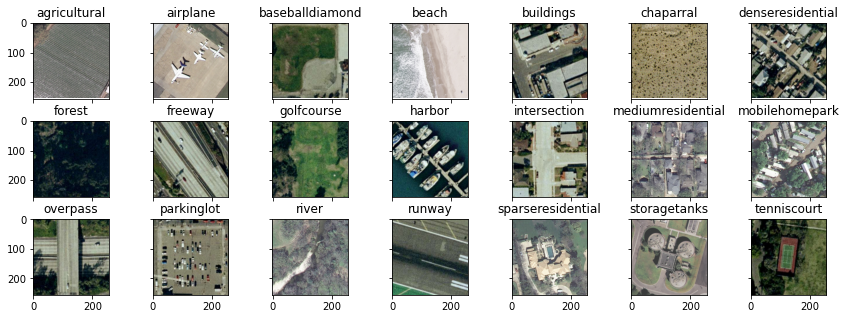

In [15]:
#pintamos las imagenes
from matplotlib import image
from matplotlib import pyplot

nrows = 3
ncols = int(len(labels_name)/nrows)

fig, ax = plt.subplots(nrows, ncols, figsize=(15,5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0)
for i, axi in enumerate(ax.flat):
    axi.imshow(image.imread(category_image[i]))
    axi.set_title(labels_name[i])

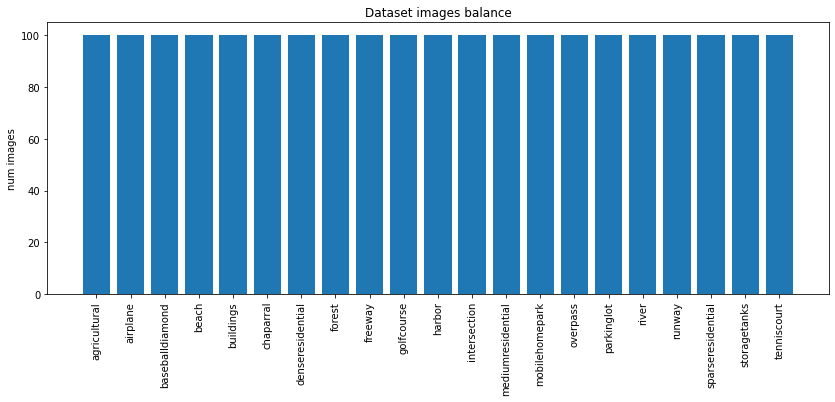

In [16]:
plt.figure(figsize=(14,5))
plt.bar(labels_name, total)
plt.title("Dataset images balance")
plt.ylabel("num images")
plt.xticks(rotation=90)
plt.show()

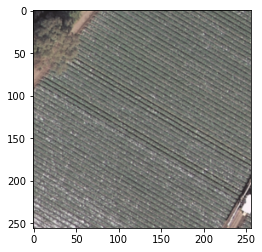

In [17]:
plt.imshow(imread(category_image[0]))
plt.show()

Se trata de un dataset completamente balanceado, en el histograma anterior se puede apreciar el número total de imágenes por clases (100 imágenes), todas la imágenes con la misma dimension 256x256 píxeles y con interpretación fotométrica de RGB y la unidad de resolución de 2 bits.

La clase [ImageDataGenerator](https://keras.io/api/preprocessing/image/) nos permite cargar las imágenes, aplicar diferentes normalizaciones, técnicas de aumentación (random flip, rotation, etc) así como definir el porcentaje de los datos que queremos usar para validación. 
Además, esta clase contiene el método *flow_from_directory*; que resulta muy útil para cuando tenemos las imágenes organizadas por directorios (que corresponden a las diferentes categorías).

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.33)
train = datagen.flow_from_directory(dir_imgs,
                                    shuffle=False,
                                    target_size=(256, 256),
                                    subset='training',
                                    class_mode='categorical')

val = datagen.flow_from_directory(dir_imgs,
                                    shuffle=False,
                                    target_size=(256, 256),
                                    subset='validation',
                                    class_mode='categorical')

Found 1407 images belonging to 21 classes.
Found 693 images belonging to 21 classes.


## 2. Modelo *Baseline* 

Vamos a entrenar y evaluar un modelo muy sencillo completamente conectado para establecer unos resultados de referencia.

Para ello, definiremos un modelo en el que se realizará un *resize* de las imágenes de entrada a un tamaño de (32,32) y 
un *flattening* de los píxeles para así generar un vector unidimensional de 3072 dimensiones (32x32x3). 
Entrenaremos un clasificador (una red completamente conectada) para clasificar entre las 21 categorías de nuestros datos.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.


<div>
Implementaremos un modelo que reduzca las dimensiones de entrada de (256,256) a (32,32) y tenga dos capas completamente conectadas: la primera de 1024 dimensiones con acticación ReLU y la última de 21 correspondinte a la clasificación final. También se hace uso dropout entre las capas completamente conectadas (probabilidad 0.5) y el optimizador Adam con  <i>learning rate</i> de 0.0001.

 Entrenaremos durante 50 épocas utilizando  <i>EarlyStopping</i> monitoreando la función de pérdida en el conjunto de validación. Y Monitoreando la métrica  <i>accuracy</i> durante entrenamiento y validación.
</div>

In [39]:
classes = len(labels_name) #21 differents classes
lr = 0.0001
epochs = 50

In [40]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2,
    restore_best_weights=True,
)

In [41]:
model = Sequential()
model.add(Input(shape=(256, 256, 3)))
model.add(Resizing(height=32, width=32))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
hist = model.fit(train, epochs=epochs, validation_data=val, callbacks=[early_stopping])

Epoch 1/50
44/44 [==============================] - 3s 52ms/step - loss: 4.0460 - accuracy: 0.0197 - val_loss: 3.1490 - val_accuracy: 0.0577
Epoch 2/50
44/44 [==============================] - 2s 49ms/step - loss: 3.3384 - accuracy: 0.0230 - val_loss: 3.0856 - val_accuracy: 0.0462
Epoch 3/50
44/44 [==============================] - 2s 49ms/step - loss: 3.2308 - accuracy: 0.0407 - val_loss: 3.0503 - val_accuracy: 0.0649
Epoch 4/50
44/44 [==============================] - 2s 49ms/step - loss: 3.0792 - accuracy: 0.0574 - val_loss: 3.0239 - val_accuracy: 0.0678
Epoch 5/50
44/44 [==============================] - 2s 49ms/step - loss: 3.0460 - accuracy: 0.0791 - val_loss: 3.0269 - val_accuracy: 0.0620
Epoch 6/50
44/44 [==============================] - 2s 49ms/step - loss: 3.0372 - accuracy: 0.0649 - val_loss: 3.0215 - val_accuracy: 0.0606
Epoch 7/50
44/44 [==============================] - 2s 49ms/step - loss: 3.0147 - accuracy: 0.0747 - val_loss: 3.0268 - val_accuracy: 0.0880
Epoch 8/50
44

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                21525     
Total params: 3,168,277
Trainable params: 3,168,277
Non-trainable params: 0
_________________________________________________________________


In [44]:
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train acc', 'Val acc'], loc='upper right')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epochs') 
    plt.legend(['Train loss', 'Val loss'], loc='upper right') 
    plt.show()

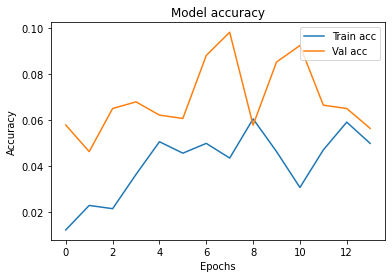

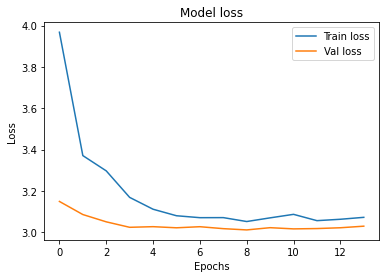

In [45]:
plot_accuracy(hist)
plot_loss(hist)

In [46]:
from sklearn.metrics import classification_report

In [47]:
val_pred=model.predict(val,verbose=0)
predicted_class_indices=np.argmax(val_pred,axis=1)

In [48]:
labels = (val.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
val_labels = [labels[k] for k in val.labels]

In [49]:
print(f'\n Report:\n {classification_report(val_labels, predictions)}')


 Report:
                    precision    recall  f1-score   support

     agricultural       0.00      0.00      0.00        33
         airplane       0.05      0.67      0.09        33
  baseballdiamond       0.00      0.00      0.00        33
            beach       0.33      0.12      0.18        33
        buildings       0.11      0.09      0.10        33
        chaparral       0.00      0.00      0.00        33
 denseresidential       0.10      0.09      0.10        33
           forest       0.00      0.00      0.00        33
          freeway       0.33      0.03      0.06        33
       golfcourse       0.00      0.00      0.00        33
           harbor       1.00      0.03      0.06        33
     intersection       0.00      0.00      0.00        33
mediumresidential       0.00      0.00      0.00        33
   mobilehomepark       0.04      0.06      0.05        33
         overpass       0.00      0.00      0.00        33
       parkinglot       0.20      0.06      

## 3. Red convolucional pequeña 

Las redes convolucionales (CNN) son especialmente adecuadas para modelar datos donde hay patrones en 2 dimensiones, como es el caso de las imágenes. En la tarea de clasificación, las CNN consisten en dos grandes bloques:

* **Bloque extractor de características**: En este bloque se generan diferentes niveles de abstracción de la imagen de entrada mediante capas convolucionales. Cuanto más profundas son estas capas, más preparadas están para la tarea de clasificación.
* **Clasificador**: Este bloque está formado por capas totalmente conectadas, la salida de deste bloque será la probabilidad asociada a cada clase.

En el apartado anterior, el bloque "extractor de características" era extremadamente simple. En este apartado, vamos a hacer uso de capas convolucionales para poder aprender mejores abstracciones de las imágenes de entrada con el fin de mejorar su clasificación.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/), [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/), [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) [GlobalAveragePooling2D](), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras. Utilizaremos la capa [Resizing]() para reducir el tamaño de la imagen a (32,32), como en el apartado anterior.


<div>
Implementaremos una red de 3 capas convolucionales (C) seguidas por una capa de  <i>average pooling</i> (AvPool) para reducir las dimensiones a un vector de 1024 dimensiones. La primera capa del modelo aplicará un  <i>resize</i> (R) a los datos de entrada para fijar las dimensiones espaciales (32,32). El clasificador final sigue la estructura del modelo del apartado anterior: dos capas completamente conectadas (D) de 1024 dimensiones la primera con activación ReLU y 21 dimensiones la última (correspondiente a la salida de la red), utilizando Dropout (Drop) entre ambas capas (probabilidad 0.5).
    
A cada capa convolucional le siguen consecutivamente una capa de  <i>Batch Normalizacion</i> (BN) y otra de  <i>Max Pooling</i> (MaxPool). El tamaño de kernel para las capas convolucionales es de (3x3), se utilizará stride de 1, padding ' <i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 32, 64 y 128. Para las capas de  <i>Max Pooling</i>, utilizaremos un kernel de 2x2 con stride 2. Utilizaremos el optimizador  <i>Adam</i> con  <i>learning rate</i> de 0.0001. Y el entranamiento será 50 épocas utilizando EarlyStopping monitoreando la función de pérdida en el conjunto de validación y la métrica  <i>accuracy</i> durante entrenamiento y validación. 
    
 El resumen de la arquitectura:

R --> C32-BN-Maxpool --> C64-BN-Maxpool --> C128-BN-MaxPool --> AvPool --> D1024-Drop-D21 
</div>

In [50]:
model2 = Sequential()
model2.add(Input(shape=(256, 256, 3)))
model2.add(Resizing(height=32, width=32))

model2.add(Conv2D(32,kernel_size=(3, 3),strides=1,padding='same', activation='relu')) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides = 2)) 


model2.add(Conv2D(64,kernel_size=(3, 3),strides=1,padding='same',activation='relu')) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides = 2)) 

model2.add(Conv2D(128,kernel_size=(3, 3),strides=1,padding='same',activation='relu')) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2), strides = 2))

model2.add(GlobalAveragePooling2D())
           
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(21, activation='softmax'))

In [51]:
early_stopping2 = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=2,
    restore_best_weights=True,
)

In [52]:
model2.compile(loss='categorical_crossentropy', 
               optimizer=Adam(lr=lr), 
               metrics=['accuracy'])

hist2 = model2.fit(train, 
                   epochs=epochs, 
                   validation_data=val, 
                   callbacks=[early_stopping2])



Epoch 1/50
44/44 [==============================] - 6s 55ms/step - loss: 3.2825 - accuracy: 0.0450 - val_loss: 3.0456 - val_accuracy: 0.0837
Epoch 2/50
44/44 [==============================] - 2s 50ms/step - loss: 3.1188 - accuracy: 0.0654 - val_loss: 3.0499 - val_accuracy: 0.0476
Epoch 3/50
44/44 [==============================] - 2s 49ms/step - loss: 3.0391 - accuracy: 0.0758 - val_loss: 3.0561 - val_accuracy: 0.0476
Epoch 4/50
44/44 [==============================] - 2s 49ms/step - loss: 2.9751 - accuracy: 0.1245 - val_loss: 3.0669 - val_accuracy: 0.0476
Epoch 5/50
44/44 [==============================] - 2s 49ms/step - loss: 2.9467 - accuracy: 0.1054 - val_loss: 3.0812 - val_accuracy: 0.0519
Epoch 6/50
44/44 [==============================] - 2s 49ms/step - loss: 2.8701 - accuracy: 0.1497 - val_loss: 3.1006 - val_accuracy: 0.0519
Epoch 7/50
44/44 [==============================] - 2s 49ms/step - loss: 2.8552 - accuracy: 0.1459 - val_loss: 3.1089 - val_accuracy: 0.0592
Epoch 8/50
44

In [53]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

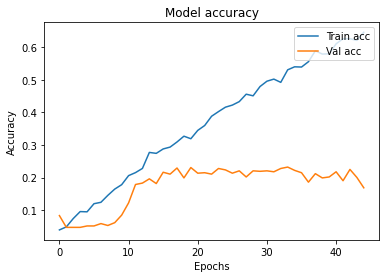

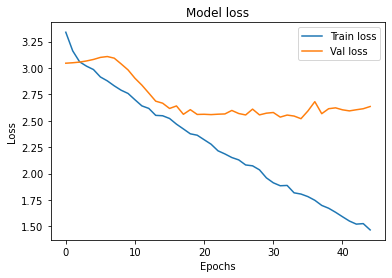

In [54]:
plot_accuracy(hist2)
plot_loss(hist2)

Parece que el modelo no esta generalizando correctamente, entre el epoch 15-20 empieza a indicar la imposibilidad de obtener resutlados correctos en el set de validación (overfitting), puede que se deba a por carecer suficiente muestras de entramient/muestras muy similares entre sus clases, haciendo que únicamente pueda producir resultados singulares.

In [55]:
val_pred2=model2.predict_generator(val,verbose=0)
predicted_class_indices2=np.argmax(val_pred2,axis=1)

In [56]:
predictions2 = [labels[k] for k in predicted_class_indices2]

In [57]:
print(f'\n Report:\n {classification_report(val_labels, predictions2)}')


 Report:
                    precision    recall  f1-score   support

     agricultural       0.33      0.39      0.36        33
         airplane       0.00      0.00      0.00        33
  baseballdiamond       0.19      0.15      0.17        33
            beach       0.50      0.21      0.30        33
        buildings       0.00      0.00      0.00        33
        chaparral       0.60      0.91      0.72        33
 denseresidential       0.00      0.00      0.00        33
           forest       0.58      0.21      0.31        33
          freeway       0.07      0.03      0.04        33
       golfcourse       0.20      0.33      0.25        33
           harbor       0.72      0.55      0.62        33
     intersection       0.00      0.00      0.00        33
mediumresidential       0.00      0.00      0.00        33
   mobilehomepark       0.36      0.24      0.29        33
         overpass       0.05      0.06      0.05        33
       parkinglot       0.22      0.85      

La clase **chaparral** ha mejorado con respecto a las otras, con una precisión del 60% y un 72% en la f1-score, puede que se deba a que la imágenes visualmente se representa visualmente facilmene por los colores representativos, un marrón claro (en general), esto hace que no sea tan similar en comparación con las otras clases, como mediumresidential/denseresidential/sparseresidential que tienen aspectos visuales muy similares. 

### 3.1 Visualización de capas intermedias

La visualización de las activaciones de una CNN es un mecanismo muy útil para comprender qué tipo de información aprende el modelo.

En este apartado vamos a visualizar las activaciones de la tercera capa convolucional del modelo entrenado anteriormente para determinar qué regiones de la imagen contribuyen más (muestran más activación) para la clasificación final.

In [58]:
import random
CATEGORY_AIRPLANE = 'airplane'
image_airp = random.choice(os.listdir(dir_imgs + "\\" + CATEGORY_AIRPLANE))
image_select = imread(dir_imgs + "\\" + CATEGORY_AIRPLANE + "\\" + image_airp)


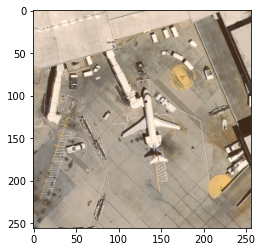

In [59]:
plt.imshow(image_select)
plt.show()

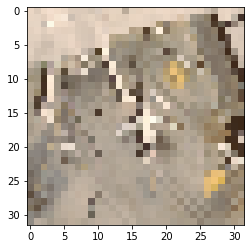

In [60]:
img_second= cv2.resize(image_select, (32, 32))
plt.imshow(img_second)
plt.show()                               

In [947]:
# img_thrid= cv2.resize(image_select, (8, 8))
# plt.imshow(img_thrid)
# plt.show()     

In [64]:
# iteramos las capas del modelo, guardamos los output de las capas conv
conv_layers = []
for i in range(0, len(model2.layers)):
    if 'conv' in model2.layers[i].name:
        conv_layers.append(model2.layers[i].output) 
        print(model2.layers[i].name, model2.layers[i].output.shape) 

conv2d (None, 32, 32, 32)
conv2d_1 (None, 16, 16, 64)
conv2d_2 (None, 8, 8, 128)


In [67]:
# adaptamos la imagen
img_tens = np.expand_dims(image_select, axis=0)
img_tens = np.float32(image_select) / 255.0 
img_tens = img_tens[np.newaxis]

In [68]:
model_activ = Model(inputs=model2.input, outputs=conv_layers[2]) # [2] == 3ra capa conv
activations = model_activ.predict(img_tens) 

In [69]:
activations.shape

(1, 8, 8, 128)

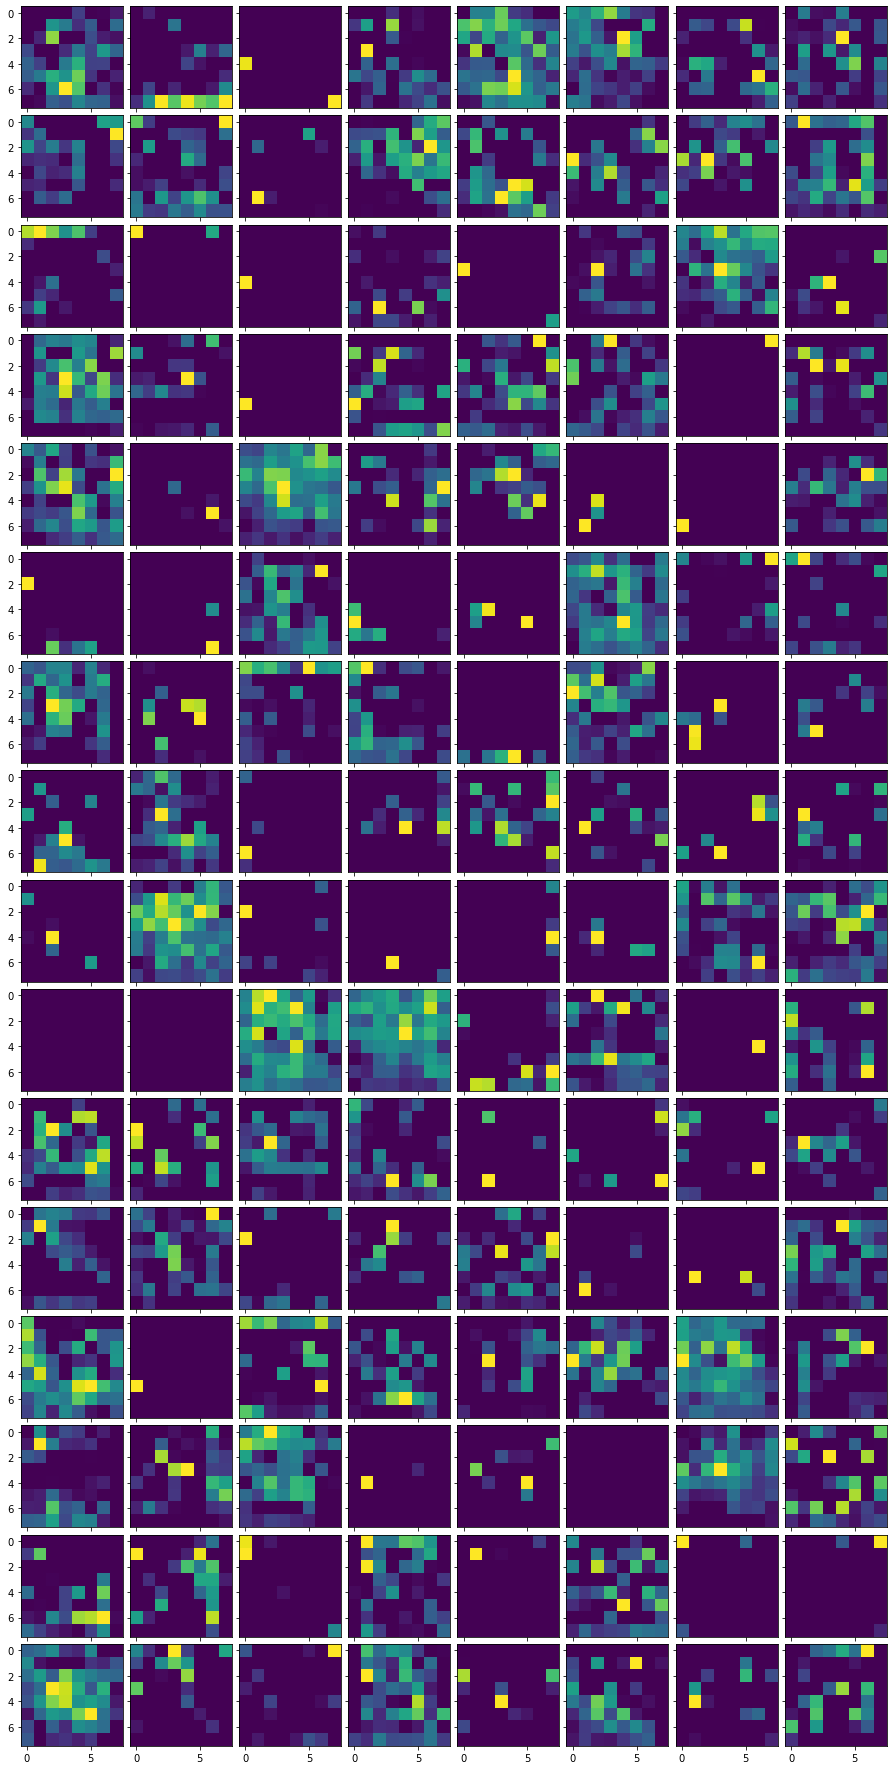

In [70]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(32., 32.))
grid = ImageGrid(fig, 111, nrows_ncols=(16, 8), axes_pad=0.1)

images_plot = []
for i in range(0, 128):
    images_plot.append(activations[0, :, :, i])
    
for ax, im in zip(grid, images_plot):
    ax.imshow(im)
plt.show()

Se muestra el grid de imágenes de la última capa de activación cnn, en concreto esta activación es más abstracta ya que es la última y a medida que avanzamos en las capas, las activaciones se vuelven cada vez menos interpretables visualmente. Puede ser que a partir de este nivel lleven más información relacionada con la clase de la imagen en lugar del contenido visual.

## 4. Red convolucional profunda - Transfer learning - Feature Extraction

Las redes convolucionales profundas nos permiten aumentar la capacidad de aprendizaje del modelo. Las arquitecturas comunes como la Resnet, pueden llegan a tener cientos de capas convolucionales. Sin embargo, entrenar desde cero estas arquitecturas es costoso (en tiempo y recursos), además de requerir conjuntos de datos bastante grandes.

En este apartado, aplicaremos  <i>transfer learning</i>. Esta metodología consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra tarea. En concreto, una [Resnet50](https://keras.io/api/applications/resnet/#resnet50-function) pre-entrenada en [Imagenet](http://www.image-net.org/), la adaptaremos para clasificar las 21 categorías de nuestra base de datos.

Para re-utilizar el modelo correctamente es necesario preprocesar los datos tal y como se hizo durante el entrenamiento en la base de datos original (se normalizó la media y la desviación estándar según las estadísticas de Imagenet). Keras nos facilita aplicar la normalización en el caso de modelos pre-entrenados; para el caso de Resnet50 revisar la documentación de [prepocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input) (tened en cuenta que la función se aplica sobre imágenes con rango dinámico de 0 a 255).


<div>
 Implementaremos un Resnet50 que parta de los pesos pre-entrenados en Imagenet exceptuando de la última capa. Esta última capa se adaptará para clasificar entre las 21 clases de nuestro dataset. Deberá adaptarse el tamaño de la imagen a (224,224) y aplicar la misma normalización que la aplicada durante el entrenamiento en Imagenet. 
    
  Resumen modelo:

Resizing--> Normalización Imagenet --> Resnet50 --> Clasificación21
</div>

In [72]:
from keras import applications
from tensorflow.keras.layers import Lambda
from tensorflow.image import resize
from keras.applications.resnet import preprocess_input

In [73]:
pretrained_model = applications.ResNet50(
    input_shape = (224, 224, 3),
    include_top=False, 
    weights='imagenet')

In [74]:
for layer in pretrained_model.layers[:-1]:
    layer.trainable = False

In [75]:
# para comprobar que la última es la entrenable
for i, layer in enumerate(pretrained_model.layers):
    print(i, layer.name, ' - ',layer.trainable )


0 input_4  -  False
1 conv1_pad  -  False
2 conv1_conv  -  False
3 conv1_bn  -  False
4 conv1_relu  -  False
5 pool1_pad  -  False
6 pool1_pool  -  False
7 conv2_block1_1_conv  -  False
8 conv2_block1_1_bn  -  False
9 conv2_block1_1_relu  -  False
10 conv2_block1_2_conv  -  False
11 conv2_block1_2_bn  -  False
12 conv2_block1_2_relu  -  False
13 conv2_block1_0_conv  -  False
14 conv2_block1_3_conv  -  False
15 conv2_block1_0_bn  -  False
16 conv2_block1_3_bn  -  False
17 conv2_block1_add  -  False
18 conv2_block1_out  -  False
19 conv2_block2_1_conv  -  False
20 conv2_block2_1_bn  -  False
21 conv2_block2_1_relu  -  False
22 conv2_block2_2_conv  -  False
23 conv2_block2_2_bn  -  False
24 conv2_block2_2_relu  -  False
25 conv2_block2_3_conv  -  False
26 conv2_block2_3_bn  -  False
27 conv2_block2_add  -  False
28 conv2_block2_out  -  False
29 conv2_block3_1_conv  -  False
30 conv2_block3_1_bn  -  False
31 conv2_block3_1_relu  -  False
32 conv2_block3_2_conv  -  False
33 conv2_block3_2_b

In [76]:
model3 = Sequential()

model3.add(Input(shape=(256, 256, 3)))
model3.add(Resizing(height=224, width=224))

model3.add(BatchNormalization())

model3.add(Lambda(lambda image: preprocess_input(image)))
model3.add(pretrained_model)

model3.add(Flatten())
# model3.add(GlobalAveragePooling2D())

model3.add(Dense(21, activation='softmax'))

In [77]:
model3.compile(loss='categorical_crossentropy', 
               optimizer=Adam(lr=lr), 
               metrics=['accuracy'])

hist3 = model3.fit(train, 
                   epochs=epochs, 
                   validation_data=val, 
                   callbacks=[early_stopping2])

Epoch 1/50
44/44 [==============================] - 13s 217ms/step - loss: 5.1014 - accuracy: 0.0557 - val_loss: 4.3943 - val_accuracy: 0.0476
Epoch 2/50
44/44 [==============================] - 8s 173ms/step - loss: 1.7862 - accuracy: 0.4307 - val_loss: 4.6504 - val_accuracy: 0.0548
Epoch 3/50
44/44 [==============================] - 8s 173ms/step - loss: 0.9642 - accuracy: 0.6825 - val_loss: 4.1548 - val_accuracy: 0.0693
Epoch 4/50
44/44 [==============================] - 8s 173ms/step - loss: 0.4686 - accuracy: 0.8692 - val_loss: 3.7409 - val_accuracy: 0.1270
Epoch 5/50
44/44 [==============================] - 8s 174ms/step - loss: 0.3894 - accuracy: 0.9069 - val_loss: 2.3316 - val_accuracy: 0.3218
Epoch 6/50
44/44 [==============================] - 8s 175ms/step - loss: 0.3284 - accuracy: 0.9132 - val_loss: 1.7436 - val_accuracy: 0.4661
Epoch 7/50
44/44 [==============================] - 8s 174ms/step - loss: 0.1719 - accuracy: 0.9669 - val_loss: 1.6446 - val_accuracy: 0.4892
Epoch

In [78]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 21)                2107413   
Total params: 25,695,137
Trainable params: 2,107,419
Non-trainable params: 23,587,718
__________________________________

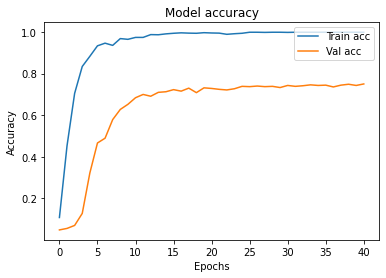

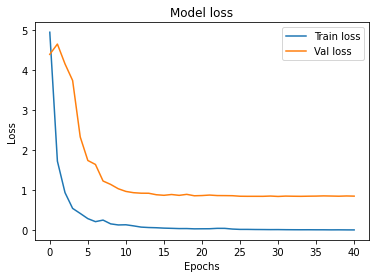

In [79]:
plot_accuracy(hist3)
plot_loss(hist3)

In [80]:
val_pred3=model3.predict_generator(val,verbose=0)
predicted_class_indices3=np.argmax(val_pred3,axis=1)

In [81]:
predictions3 = [labels[k] for k in predicted_class_indices3]

In [82]:
print(f'\n Report:\n {classification_report(val_labels, predictions3)}')


 Report:
                    precision    recall  f1-score   support

     agricultural       0.94      0.88      0.91        33
         airplane       0.94      0.91      0.92        33
  baseballdiamond       0.79      0.82      0.81        33
            beach       0.81      0.91      0.86        33
        buildings       0.56      0.55      0.55        33
        chaparral       0.92      1.00      0.96        33
 denseresidential       0.37      0.33      0.35        33
           forest       0.74      0.94      0.83        33
          freeway       0.74      0.85      0.79        33
       golfcourse       0.69      0.55      0.61        33
           harbor       0.94      0.97      0.96        33
     intersection       0.82      0.70      0.75        33
mediumresidential       0.55      0.64      0.59        33
   mobilehomepark       0.55      0.55      0.55        33
         overpass       0.80      0.85      0.82        33
       parkinglot       0.89      0.97      

In [83]:
from sklearn.metrics import confusion_matrix
import itertools

In [84]:
cm = confusion_matrix(val_labels, predictions3)

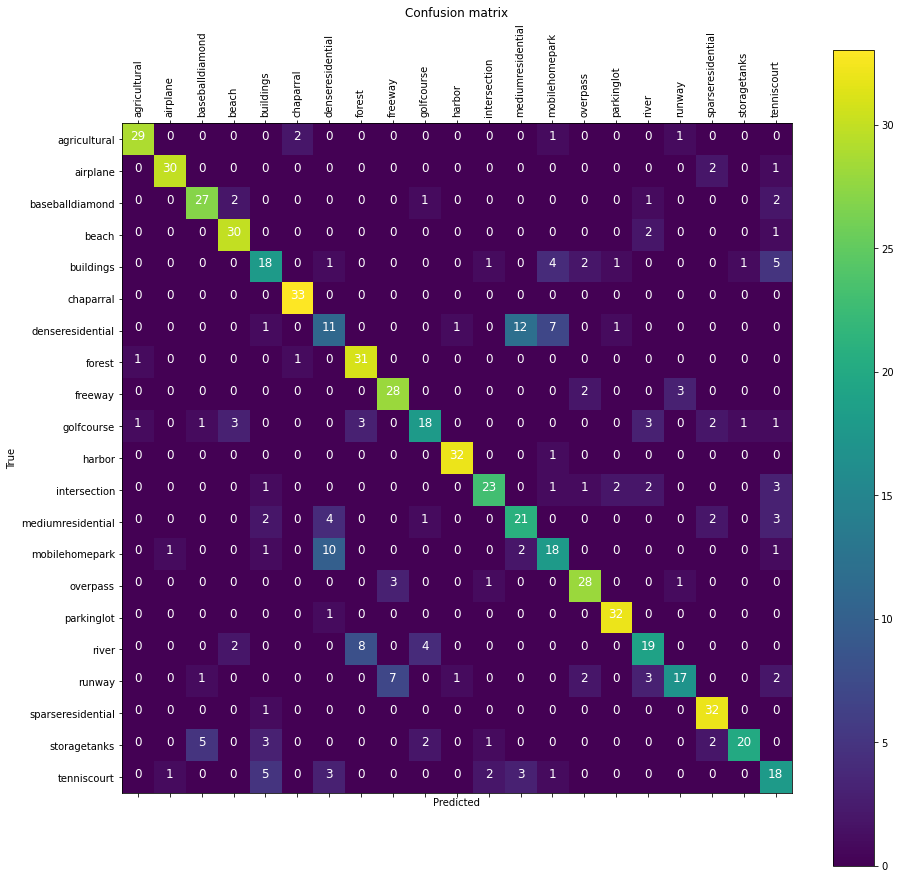

In [85]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

plt.title('Confusion matrix')
fig.colorbar(cax)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j],'d'),
             horizontalalignment="center",
             color="white", 
             fontsize=12)
    
ticks = np.arange(len(labels_name))
plt.xticks(ticks, labels_name, rotation=90)
plt.yticks(ticks, labels_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [86]:
# guardamos en una tupla el (indice, el nombre de la clase predicted, y la verdadera clase )
# si se quiere pintar mas de una imagen solo iterar la tupla
# val es el conjunto de valiacion objeto datagen
INDEX = 0
PREDICTED = 1
TRUE_CLASS = 2

bad_pred = []
for i in range(0, len(predictions3)):
    if predictions3[i] != val_labels[i]:
        bad_pred.append(tuple([i, predictions3[i], val_labels[i]]))

image_bad = random.sample(bad_pred, 1)
image_bad

[(158, 'denseresidential', 'buildings')]

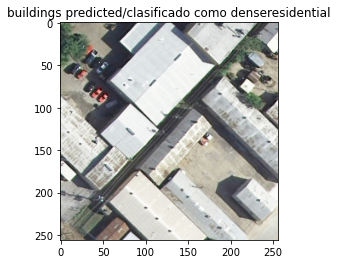

In [87]:
image = imread(dir_imgs + "\\" + val.filenames[image_bad[INDEX][INDEX]])
plt.imshow(image)
plt.title(image_bad[INDEX][TRUE_CLASS] + ' predicted/clasificado como ' + image_bad[INDEX][PREDICTED])
plt.show()

## 5. Conclusiones 


|model   | accuracy_validation  | # epochs  | # parameters  | 
|---|:---:|:---:|:---:|
|Baseline   | 11%  | 50 | 3,168,277 |
|Small CNN   | 21%  | 50 | 247,765 |
|Resnet50   | 74%  | 50 | 25,695,137  |

En general los resultados obtenidos han mejorado con el último modelo usando los weights de otro modelo ya entrenado (resnet50), cambiando la dimensión 224x224, haciendo un reajuste debido a como estaba construido el modelo y manteniendo la estructura de las capas excepto la última como si fuera una continuación, todo esto contribuyó a obtener un mejor resultado. Los otros modelos han presentado resultados bajos y overfitting, el modelo baseline con el resultado más bajo obtenido un, 11% de precisión, el small cnn mejoró x2 la precisión del modelo baseline y el modelo preentrado resnet consiguiendo casi un 74% de precisión. 